# 📊 Civil Comments Dataset Exploration

This notebook performs a basic exploration of the [Civil Comments Dataset](https://huggingface.co/datasets/civil_comments), which contains user comments labeled for toxicity and identity-based references. The dataset is useful for projects focused on detecting hate speech, bias, and discrimination in online conversations.

### 🔍 What this notebook does:

- Loads the dataset using the Hugging Face `datasets` library (no manual download required)
- Displays the dataset structure, number of samples, and feature names
- Shows sample comment entries
- Identifies which columns represent **religion-related identity attributes** (e.g. `muslim`, `jewish`, `christian`, etc.)
- Counts how many comments in the dataset reference religious identities based on thresholding

### 📌 Why Civil Comments?

For our project on detecting **religious discrimination in YouTube comments**, this dataset offers:
- Real-world online comments (collected from news sites)
- Annotations related to both **toxicity** and **specific identities**, including religions
- Public availability under a permissive license

This notebook serves as a starting point for analyzing, filtering, and eventually training models to detect religious hate speech.


In [4]:
# civil_comments_exploration.ipynb

# 🛠️ Install necessary package
!pip install datasets --quiet

# 📚 Load dataset from Hugging Face
from datasets import load_dataset

print("🔄 Loading 'civil_comments' dataset...")
dataset = load_dataset("civil_comments")

# 🧱 Check structure: split names
print("\n✅ Dataset splits:")
print(dataset)

# 🔍 Look at the features/columns
print("\n🧬 Features in 'train' split:")
print(dataset['train'].features)

# 📏 Size of dataset
print("\n📊 Number of examples:")
for split in dataset:
    print(f"{split}: {len(dataset[split])} samples")

# 👀 Show a few sample rows
print("\n📝 Sample entries:")
for i in range(3):
    print(f"\nExample {i+1}")
    print(dataset['train'][i])

# 🧠 Identity tags check (these are useful for religion detection)
identity_columns = [col for col in dataset['train'].features if dataset['train'].features[col].dtype == 'float32']
print("\n🧪 Identity tag columns (float labels between 0 and 1):")
print(identity_columns)

# 📊 Basic stats: how many comments reference religion?
import pandas as pd

# Convert a small subset to pandas for quick inspection
df = dataset['train'].to_pandas()




🔄 Loading 'civil_comments' dataset...

✅ Dataset splits:
DatasetDict({
    train: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
        num_rows: 1804874
    })
    validation: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
        num_rows: 97320
    })
    test: Dataset({
        features: ['text', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit'],
        num_rows: 97320
    })
})

🧬 Features in 'train' split:
{'text': Value(dtype='string', id=None), 'toxicity': Value(dtype='float32', id=None), 'severe_toxicity': Value(dtype='float32', id=None), 'obscene': Value(dtype='float32', id=None), 'threat': Value(dtype='float32', id=None), 'insult': Value(dtype='float32', id=None), 'identity_attack': Value(dtype='float32', id=None), 'sexual_explicit': Value(dtype

In [7]:
import re

# 🔍 Define a simple list of religion-related keywords
religion_keywords = [
    "muslim", "islam", "islamic", "jew", "jewish", "judaism",
    "christian", "christianity", "bible", "jesus", "god", "catholic", "pope",
    "hindu", "hinduism", "buddha", "buddhist", "atheist", "religion", "religious"
]

# 🏷️ Function to check if any keyword exists in a comment (case-insensitive)
def mentions_religion(text):
    text = str(text).lower()
    return any(re.search(rf"\b{kw}\b", text) for kw in religion_keywords)

# 🧠 Apply function to create a new label
df['mentions_religion'] = df['text'].apply(mentions_religion)

# 📊 Stats
print("🧮 Total comments mentioning religion:", df['mentions_religion'].sum())

# 👀 Preview some samples
print("\n💬 Example religion-related comment:")
print(df[df['mentions_religion']].sample(1)['text'].values[0])

🧮 Total comments mentioning religion: 96636

💬 Example religion-related comment:
'Bannon is unlikely to want Trump to force American Catholics to choose between their president and their pope.'  

Dionne is myopic in the extreme.  Yes, Bannon will force this decision while he hides behind Trump. He considers Trump the Grey Ghost.   This is precisely why I think they will use bio/viral attacks to close the borders.  How many of us would say 'yes' to Ebola or some other derivative. I truly can't say I would disagree with closing the borders with a plague overseas. I sure hope the NSA folks are putting some dots together.


In [9]:
# 🏷️ Define religious hate as religion-related + toxic
df['religious_hate'] = (df['mentions_religion']) & (df['toxicity'] > 0.5)

# ✅ Filter to just religion-related comments with weak label
df_filtered = df[df['mentions_religion']].copy()

# ✅ Drop rows with missing or weird content
df_filtered = df_filtered[df_filtered['text'].notna()]

# ✅ Convert hate speech to binary label
df_filtered['label'] = df_filtered['religious_hate'].astype(int)

# ✅ Show class distribution
print("🔢 Label distribution (0 = not hate, 1 = hate):")
print(df_filtered['label'].value_counts())

# ✅ Split into train / validation / test
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_filtered['text'], df_filtered['label'], test_size=0.2, stratify=df_filtered['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

# 📊 Check sizes
print(f"\nTrain size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")


🔢 Label distribution (0 = not hate, 1 = hate):
label
0    89818
1     6818
Name: count, dtype: int64

Train size: 77308
Validation size: 9664
Test size: 9664


In [21]:
# ✅ Install tiny model if needed
!pip install transformers datasets scikit-learn --quiet

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import pandas as pd

# ✅ Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Using device:", device)

# ✅ Balance the training dataset: 1000 hate + 1000 non-hate
hate_train = df_filtered[df_filtered['label'] == 1].sample(n=6000, random_state=42)
non_hate_train = df_filtered[df_filtered['label'] == 0].sample(n=6000, random_state=42)
train_df = pd.concat([hate_train, non_hate_train]).sample(frac=1, random_state=42)

train_texts = train_df['text']
train_labels = train_df['label']

# ✅ Keep validation set small (stratified sample)
val_sampled = val_texts.sample(n=1000, random_state=42)
val_labels_sampled = val_labels[val_sampled.index]

# ✅ Tiny model for fast testing
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# ✅ Dataset wrapper
class CommentDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=256)
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

# ✅ Loaders
train_data = CommentDataset(train_texts, train_labels)
val_data = CommentDataset(val_sampled, val_labels_sampled)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

# ✅ Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# ✅ Training loop (1 fast epoch)
model.train()
for batch in tqdm(train_loader, desc="🚀 Training"):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# ✅ Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="🔍 Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# ✅ Metrics
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"\n✅ Validation Accuracy: {acc:.4f}")
print(f"🎯 Validation F1 Score: {f1:.4f}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


🖥️ Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  )
🔍 Evaluating: 100%|██████████| 63/63 [00:01<00:00, 45.45it/s]



✅ Validation Accuracy: 0.8210
🎯 Validation F1 Score: 0.3849



📋 Classification Report:
              precision    recall  f1-score   support

    non-hate       0.96      0.82      0.88       936
        hate       0.17      0.55      0.26        64

    accuracy                           0.80      1000
   macro avg       0.57      0.68      0.57      1000
weighted avg       0.91      0.80      0.84      1000



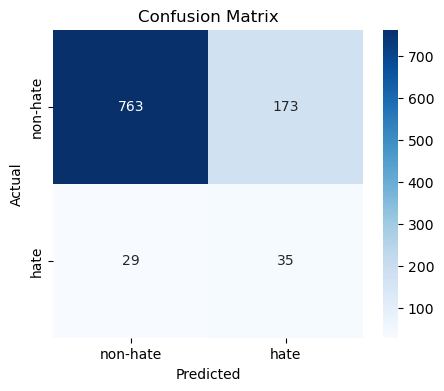


📊 Actual class distribution in validation set: Counter({0: 936, 1: 64})
🔮 Predicted class distribution: Counter({0: 792, 1: 208})


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Print classification report
print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-hate", "hate"], yticklabels=["non-hate", "hate"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Class distribution (validation set)
import collections
label_counts = collections.Counter(all_labels)
print("\n📊 Actual class distribution in validation set:", label_counts)

pred_counts = collections.Counter(all_preds)
print("🔮 Predicted class distribution:", pred_counts)


In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import torch

# ⚡ Speed settings
MAX_LENGTH = 128  # Shorter input = faster
BATCH_SIZE = 16   # Increase if you have GPU memory
EPOCHS = 2        # Reduced for quick test

# ✅ Better model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# ✅ Dataset class
class CommentDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=MAX_LENGTH)
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

# ✅ Loaders
train_data = CommentDataset(train_texts, train_labels)
val_data = CommentDataset(val_sampled, val_labels_sampled)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE * 2)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# ✅ Mixed precision (if GPU)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# ✅ Train
for epoch in range(EPOCHS):
    print(f"\n🧠 Epoch {epoch+1}/{EPOCHS}")
    model.train()
    running_loss = 0

    for batch in tqdm(train_loader, desc="🚀 Training"):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(**batch)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        running_loss += loss.item()

    print(f"📉 Avg training loss: {running_loss/len(train_loader):.4f}")

# ✅ Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="🔍 Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# ✅ Metrics
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"\n✅ Validation Accuracy: {acc:.4f}")
print(f"🎯 Validation F1 Score: {f1:.4f}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/2_/9q4sr54x3z57wwlnq2p2r1jm0000gn/T/ipykernel_43034/3702653235.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))



🧠 Epoch 1/2


🚀 Training:   0%|          | 0/750 [00:00<?, ?it/s]/var/folders/2_/9q4sr54x3z57wwlnq2p2r1jm0000gn/T/ipykernel_43034/3702653235.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
🚀 Training:  57%|█████▋    | 428/750 [10:18<07:45,  1.44s/it]  


KeyboardInterrupt: 